**Installing CatBoost Library**

In [3]:
#Installing CatBoost Library
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


**Importing Libraries**

In [4]:
#Importing Libraries
import numpy as np
import pandas as pd

#import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from IPython.display import display, Markdown, Latex

**Mounting google drive to read data.**

In [5]:
# Mounting google drive to read data.
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/credit_risk_data/german2.csv')

In [ ]:
data.head()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


**Scaling and train-test split**

In [8]:
# Split df into X and y
y = data['Creditability'].copy()
X = data.drop('Creditability', axis=1).copy()

# Scale X with a standard scaler (so that values are between -1 and 1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [ ]:
X

,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,Guarantors,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
0,-1.25,-0.24,1.34,-0.30,-0.79,-0.70,-1.15,0.92,-0.96,-0.30,1.05,-0.34,-1.28,0.46,-1.75,-0.70,0.15,-0.43,-0.82,-0.20
1,-1.25,-0.99,1.34,-1.03,-0.17,-0.70,-0.32,-0.87,0.45,-0.30,-0.77,-1.29,0.04,0.46,-1.75,1.03,0.15,2.33,-0.82,-0.20
2,-0.46,-0.74,-0.50,2.25,-0.86,-0.07,0.51,-0.87,-0.96,-0.30,1.05,-1.29,-1.11,0.46,-1.75,-0.70,-1.38,-0.43,-0.82,-0.20
3,-1.25,-0.74,1.34,-1.03,-0.41,-0.70,-0.32,0.02,0.45,-0.30,-0.77,-1.29,0.30,0.46,-1.75,1.03,-1.38,2.33,-0.82,5.10
4,-1.25,-0.74,1.34,-1.03,-0.39,-0.70,-0.32,0.92,0.45,-0.30,1.05,-0.34,0.22,-2.38,0.14,1.03,-1.38,-0.43,-0.82,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.25,0.26,-0.50,0.06,-0.46,-0.70,-0.32,-0.87,0.45,-0.30,1.05,-1.29,-1.28,0.46,-1.75,-0.70,-1.38,2.33,-0.82,-0.20
996,-1.25,0.26,-0.50,-1.03,-0.34,-0.70,1.34,0.92,0.45,1.79,-1.67,-1.29,0.83,0.46,0.14,-0.70,0.15,-0.43,-0.82,-0.20
997,1.13,0.01,1.34,-1.03,3.33,1.83,1.34,0.92,0.45,-0.30,1.05,1.56,-0.49,0.46,2.02,-0.70,1.68,-0.43,1.21,-0.20
998,-0.46,-0.74,-0.50,0.06,1.13,1.83,-1.97,-0.87,0.45,-0.30,-1.67,1.56,1.45,0.46,0.14,-0.70,1.68,-0.43,1.21,-0.20


In [ ]:
#To check for Data Imbalance
y.value_counts()

1    700
0    300
Name: Creditability, dtype: int64

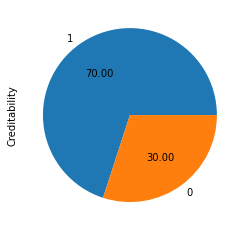

In [ ]:
# Show pie plot 
y.value_counts().plot.pie(autopct='%.2f')

In [ ]:
df = X_train
df.target = y_train

features = X_train
labels = y_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


**Feature Selection:**
We have used Six Different Feature Selection algorithm(Feed Forward, Weight of Evidence(WOE), Anova, Extra trees, Random forest, and L1 feature selection) combined using Voting Techniques(Unanimous, Majority, Hard-voting, Soft-voting, Any_Vote)

1. Weight of Evidence(WOE)

In [ ]:
# Implementation for Weight of Evidence(WOE) feature Selection
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [ ]:
final_iv, IV = data_vars(df,df.target)

In [ ]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [ ]:
IV.sort_values(['IV'],ascending=0)

,index,IV
0,Account_Balance,0.493788
5,Duration_of_Credit_monthly,0.267667
14,Payment_Status_of_Previous_Credit,0.152525
19,Value_Savings_Stocks,0.152068
1,Age_years,0.072597
10,Most_valuable_available_asset,0.058230
9,Length_of_current_employment,0.056698
6,Foreign_Worker,0.056062
3,Credit_Amount,0.030935
18,Type_of_apartment,0.015670


2. Random Forest Feature Selection

In [ ]:
#Implementation for Random Forest Feature Selection
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

1.0


In [ ]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [ ]:
VI = VI.reset_index()

In [ ]:
VI.sort_values(['RF'],ascending=0)

,index,RF
4,Credit_Amount,0.140227
12,Age_years,0.112530
1,Duration_of_Credit_monthly,0.107919
0,Account_Balance,0.097458
3,Purpose,0.066147
6,Length_of_current_employment,0.052800
2,Payment_Status_of_Previous_Credit,0.050669
5,Value_Savings_Stocks,0.046642
11,Most_valuable_available_asset,0.045399
10,Duration_in_Current_address,0.041887


3. Feed Forward Feature Selection

In [ ]:
# Implementation of Feed Forward Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
sfs = SFS(model, n_features_to_select =18, direction="forward")
fit = sfs.fit(features, labels)

In [ ]:
from pandas import DataFrame
Selected = DataFrame(sfs.support_, columns = ["SFS"], index=features.columns)
Selected = Selected.reset_index()

In [ ]:
Selected

,index,SFS
0,Account_Balance,True
1,Duration_of_Credit_monthly,True
2,Payment_Status_of_Previous_Credit,True
3,Purpose,True
4,Credit_Amount,True
5,Value_Savings_Stocks,True
6,Length_of_current_employment,True
7,Instalment_per_cent,True
8,Sex_Marital_Status,True
9,Guarantors,True


In [ ]:
Selected[Selected['SFS'] == True]

,index,SFS
0,Account_Balance,True
1,Duration_of_Credit_monthly,True
2,Payment_Status_of_Previous_Credit,True
3,Purpose,True
4,Credit_Amount,True
5,Value_Savings_Stocks,True
6,Length_of_current_employment,True
7,Instalment_per_cent,True
8,Sex_Marital_Status,True
9,Guarantors,True


4. Extra Tree Feature Selection

In [ ]:
# Implementation of Extra Tree Feature Selection
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.1081684  0.09558667 0.05373376 0.06368856 0.07725744 0.05389395
 0.058169   0.04922162 0.04702533 0.02805935 0.04811629 0.05361342
 0.07030188 0.02990134 0.03208862 0.03126566 0.04341186 0.02177743
 0.03001366 0.00470575]


In [ ]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [ ]:
FI = FI.reset_index()

In [ ]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
0,Account_Balance,0.108168
1,Duration_of_Credit_monthly,0.095587
4,Credit_Amount,0.077257
12,Age_years,0.070302
3,Purpose,0.063689
6,Length_of_current_employment,0.058169
5,Value_Savings_Stocks,0.053894
2,Payment_Status_of_Previous_Credit,0.053734
11,Most_valuable_available_asset,0.053613
7,Instalment_per_cent,0.049222


In [ ]:
df1 = df.copy()

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [ ]:
features1 = df1
labels1 = y_train

5. Anova Feature Selection

In [ ]:
# Implementation of Anova Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

model = SelectKBest(score_func=f_classif, k=15)
fit = model.fit(features, labels)

In [ ]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[76.73797474 44.13708128 30.02143529  0.42492029 19.96930745 20.82580177
  8.75808121  0.7985314   3.03449208  0.18809065  0.01993947  9.53128954
  4.79132477  4.89523759  0.35774717  2.70175148  0.94853061  0.0047375
  1.4053743   4.76928243]


In [ ]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
anova = DataFrame(fit.scores_, columns = ["Anova"], index=features1.columns)

In [ ]:
anova = anova.reset_index()

In [ ]:
anova.sort_values('Anova',ascending=0)

,index,Anova
0,Account_Balance,76.74
1,Duration_of_Credit_monthly,44.14
2,Payment_Status_of_Previous_Credit,30.02
5,Value_Savings_Stocks,20.83
4,Credit_Amount,19.97
11,Most_valuable_available_asset,9.53
6,Length_of_current_employment,8.76
13,Concurrent_Credits,4.90
12,Age_years,4.79
19,Foreign_Worker,4.77


6. L1 based Feature Selection

In [ ]:
# Implementation of L1 based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

In [ ]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

In [ ]:
l1 = l1.reset_index()

In [ ]:
l1[l1['L1'] == True]

,index,L1
0,Account_Balance,True
1,Duration_of_Credit_monthly,True
2,Payment_Status_of_Previous_Credit,True
5,Value_Savings_Stocks,True
6,Length_of_current_employment,True


**Voting mechanism for feature selection**

In [ ]:
# Implementing Voting mechanism for feature selection
#Combining outputs of individual feature selection methods
from functools import reduce
dfs = [IV, VI, Selected, FI, anova, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [ ]:
final_results.head()

,index,IV,RF,SFS,Extratrees,Anova,L1
0,Account_Balance,0.49,0.10,True,0.11,76.74,True
1,Age_years,0.07,0.11,True,0.07,4.79,False
2,Concurrent_Credits,0.00,0.03,True,0.03,4.90,False
3,Credit_Amount,0.03,0.14,True,0.08,19.97,False
4,Duration_in_Current_address,0.00,0.04,True,0.05,0.02,False


In [ ]:
final_results.columns

Index(['index', 'IV', 'RF', 'SFS', 'Extratrees', 'Anova', 'L1'], dtype='object')

In [ ]:
#Changing the datatypes to be uniform accross all the columns and computing the final score column
columns = ['IV', 'RF', 'Extratrees', 'Anova']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(15,i)['index'])).astype(int)
    
score_table['SFS'] = final_results['SFS'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [ ]:
score_table['final_score'] = score_table.sum(axis=1)

In [ ]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Anova,SFS,L1,final_score
0,Account_Balance,1,1,1,1,1,1,6
5,Duration_of_Credit_monthly,1,1,1,1,1,1,6
14,Payment_Status_of_Previous_Credit,1,1,1,1,1,1,6
9,Length_of_current_employment,1,1,1,1,1,1,6
19,Value_Savings_Stocks,1,1,1,1,1,1,6
8,Instalment_per_cent,1,1,1,1,1,0,5
3,Credit_Amount,1,1,1,1,1,0,5
1,Age_years,1,1,1,1,1,0,5
13,Occupation,1,1,1,1,1,0,5
10,Most_valuable_available_asset,1,1,1,1,1,0,5


In [ ]:
dfScore2 = score_table[score_table.final_score > 2]

In [ ]:
len(dfScore2)

17

In [ ]:
dfScore2["index"]

0                       Account_Balance
1                             Age_years
2                    Concurrent_Credits
3                         Credit_Amount
4           Duration_in_Current_address
5            Duration_of_Credit_monthly
6                        Foreign_Worker
8                   Instalment_per_cent
9          Length_of_current_employment
10        Most_valuable_available_asset
11           No_of_Credits_at_this_Bank
13                           Occupation
14    Payment_Status_of_Previous_Credit
15                              Purpose
16                   Sex_Marital_Status
18                    Type_of_apartment
19                 Value_Savings_Stocks
Name: index, dtype: object

In [ ]:
X_train = X_train[dfScore2["index"]]
X_test = X_test[dfScore2["index"]]

In [ ]:
X_train

,Account_Balance,Age_years,Concurrent_Credits,Credit_Amount,Duration_in_Current_address,Duration_of_Credit_monthly,Foreign_Worker,Instalment_per_cent,Length_of_current_employment,Most_valuable_available_asset,No_of_Credits_at_this_Bank,Occupation,Payment_Status_of_Previous_Credit,Purpose,Sex_Marital_Status,Type_of_apartment,Value_Savings_Stocks
498,1.13,0.22,0.46,-0.83,-0.77,-0.74,-0.20,-1.76,-1.97,-0.34,-0.70,-2.91,1.34,-1.03,-0.96,0.14,-0.70
243,1.13,-0.31,-2.38,-0.94,0.14,-0.24,-0.20,0.92,1.34,-0.34,1.03,1.68,1.34,0.06,0.45,0.14,0.57
314,-1.25,0.48,0.46,-0.92,1.05,-1.24,-0.20,0.02,-1.15,-1.29,-0.70,-1.38,-0.50,-1.03,0.45,0.14,-0.70
202,0.34,1.19,-2.38,-0.65,1.05,-0.24,-0.20,0.92,0.51,0.61,-0.70,-1.38,-1.43,0.06,0.45,0.14,1.83
300,-1.25,0.83,-2.38,-1.04,-1.67,-0.74,-0.20,0.92,1.34,0.61,-0.70,-1.38,-1.43,1.89,1.86,0.14,-0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,-1.25,-1.11,0.46,-0.81,-0.77,-0.24,-0.20,-1.76,-1.15,0.61,-0.70,-1.38,-0.50,-1.03,-0.96,0.14,-0.70
322,1.13,-0.66,0.46,-0.40,-0.77,-0.82,-0.20,-1.76,1.34,-1.29,-0.70,0.15,-0.50,2.25,-2.38,0.14,1.20
382,1.13,2.42,-2.38,3.72,1.05,3.24,-0.20,-0.87,1.34,1.56,-0.70,1.68,1.34,-1.03,0.45,2.02,1.83
365,1.13,-0.14,0.46,-0.18,1.05,-0.74,-0.20,-0.87,1.34,-0.34,1.03,0.15,-2.35,-0.30,0.45,0.14,-0.70


In [ ]:
#Implementation of SMOTE for Data Balancing
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
oversample = SMOTE(sampling_strategy={0:900})
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (900) in class 0 will be larger than the number of samples in the majority class (class #1 -> 501)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (900) in class 0 will be larger than the number of samples in the majority class (class #1 -> 199)
  f"After over-sampling, the number of samples ({n_samples})"


In [ ]:
X_train

,Account_Balance,Age_years,Concurrent_Credits,Credit_Amount,Duration_in_Current_address,Duration_of_Credit_monthly,Foreign_Worker,Instalment_per_cent,Length_of_current_employment,Most_valuable_available_asset,No_of_Credits_at_this_Bank,Occupation,Payment_Status_of_Previous_Credit,Purpose,Sex_Marital_Status,Type_of_apartment,Value_Savings_Stocks
0,1.13,0.22,0.46,-0.83,-0.77,-0.74,-0.20,-1.76,-1.97,-0.34,-0.70,-2.91,1.34,-1.03,-0.96,0.14,-0.70
1,1.13,-0.31,-2.38,-0.94,0.14,-0.24,-0.20,0.92,1.34,-0.34,1.03,1.68,1.34,0.06,0.45,0.14,0.57
2,-1.25,0.48,0.46,-0.92,1.05,-1.24,-0.20,0.02,-1.15,-1.29,-0.70,-1.38,-0.50,-1.03,0.45,0.14,-0.70
3,0.34,1.19,-2.38,-0.65,1.05,-0.24,-0.20,0.92,0.51,0.61,-0.70,-1.38,-1.43,0.06,0.45,0.14,1.83
4,-1.25,0.83,-2.38,-1.04,-1.67,-0.74,-0.20,0.92,1.34,0.61,-0.70,-1.38,-1.43,1.89,1.86,0.14,-0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,-0.46,-0.90,0.46,0.77,-0.19,2.25,-0.20,0.31,0.51,-0.65,-0.15,0.15,-0.50,-0.68,0.45,0.14,-0.27
1397,1.13,-0.26,0.46,-0.86,0.21,-0.75,-0.20,0.92,1.22,-0.34,-0.70,-1.38,1.21,-0.02,-0.86,0.14,1.83
1398,-0.46,-1.02,0.46,1.16,-0.77,2.25,-0.20,0.01,0.50,-0.35,-0.70,0.15,-0.50,-1.02,0.43,0.14,-0.07
1399,-0.79,0.96,0.46,1.92,0.70,1.45,-0.20,-0.15,1.02,1.56,-0.70,0.15,-0.15,-0.74,0.45,2.02,1.59


**Modelling**

In [ ]:
# For Model Performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
## Hyperparameter optimization using GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV

In [ ]:
## Hyper Parameter Optimization

params_xgb={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [ ]:
classifier = XGBClassifier() 
random_search_xgb=RandomizedSearchCV(classifier,param_distributions=params_xgb,n_iter=5,scoring='roc_auc',n_jobs=-1,verbose=3, cv=2)
#grid_xgb = GridSearchCV(classifier, param_grid=params_xgb, verbose=1,cv=2, n_jobs=-1)
#Here we used random search since it took less time then grid.

In [ ]:
random_search_xgb.fit(X_train,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [ ]:
random_search_xgb.best_estimator_

XGBClassifier(colsample_bytree=0.5, gamma=0.2, max_depth=6)

**XGBoost**

In [ ]:
#Implementing XGBoost classifier with hyper-parameter tuning
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2,
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)# Define classifier
xgb.fit(X_train, y_train) 

# Make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Training set performance
xgb_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
xgb_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
xgb_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
xgb_train_auc = roc_auc_score(y_train, y_train_pred)


# Test set performance
xgb_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
xgb_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
xgb_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
xgb_test_auc = roc_auc_score(y_test, y_test_pred)


print('Model performance for Training set')
print('- Accuracy: %s' % xgb_train_accuracy)
print('- MCC: %s' % xgb_train_mcc)
print('- F1 score: %s' % xgb_train_f1)
print('Train AUC: %.3f' % xgb_train_auc)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % xgb_test_accuracy)
print('- MCC: %s' % xgb_test_mcc)
print('- F1 score: %s' % xgb_test_f1)
print('Test AUC: %.3f' % xgb_test_auc)

Model performance for Training set
- Accuracy: 0.9707351891506067
- MCC: 0.9366475277038725
- F1 score: 0.9707919182771061
Train AUC: 0.970
----------------------------------
Model performance for Test set
- Accuracy: 0.916287534121929
- MCC: 0.7211284124485052
- F1 score: 0.9167691739426621
Test AUC: 0.865


In [ ]:
grid_params_lightgbm = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

In [ ]:
classifier = LGBMClassifier()
grid = GridSearchCV(classifier, param_grid=grid_params_lightgbm, verbose=1, cv=2, n_jobs=-1)

In [ ]:
grid.fit(X_train,y_train)

Fitting 2 folds for each of 432 candidates, totalling 864 fits


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01], 'n_estimators': [8, 24],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
                         'reg_alpha': [1, 2, 6], 'reg_lambda': [1, 2, 6],
                         'seed': [500], 'subsample': [0.7, 0.75]},
             verbose=1)

In [ ]:
grid.best_estimator_

LGBMClassifier(colsample_bytree=0.65, learning_rate=0.01, n_estimators=24,
               num_leaves=12, objective='binary', reg_alpha=1, reg_lambda=2,
               seed=500, subsample=0.7)

In [ ]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.01,
 'n_estimators': 24,
 'num_leaves': 12,
 'objective': 'binary',
 'reg_alpha': 1,
 'reg_lambda': 2,
 'seed': 500,
 'subsample': 0.7}

**LightGBM**

In [ ]:
#Implementing LGBM classifier with hyper-parameter tuning
lgbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
               importance_type='split', learning_rate=0.4, max_depth=12,
               min_child_samples=10, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=100, n_jobs=-1, num_leaves=12, objective='binary',
               random_state=None, reg_alpha=1, reg_lambda=2, seed=500,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=0)
lgbm.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

# Training set performance
lgbm_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
lgbm_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
lgbm_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
auc_train = roc_auc_score(y_train, y_train_pred)

# Test set performance
lgbm_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
lgbm_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
lgbm_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
auc_test = roc_auc_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- Accuracy: %s' % lgbm_train_accuracy)
print('- MCC: %s' % lgbm_train_mcc)
print('- F1 score: %s' % lgbm_train_f1)
print('Train AUC: %.3f' % auc_train)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % lgbm_test_accuracy)
print('- MCC: %s' % lgbm_test_mcc)
print('- F1 score: %s' % lgbm_test_f1)
print('Test AUC: %.3f' % auc_test)

Model performance for Training set
- Accuracy: 0.9635974304068522
- MCC: 0.9214073748174593
- F1 score: 0.9636981402925446
Train AUC: 0.963
----------------------------------
Model performance for Test set
- Accuracy: 0.9262966333030027
- MCC: 0.7509986562693433
- F1 score: 0.9262242696938948
Test AUC: 0.875


In [ ]:
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [ ]:
cat = CatBoostClassifier()
cat_grid = GridSearchCV(cat, param_grid=parameters, cv = 2, verbose=1, n_jobs=-1)

In [ ]:
cat_grid.fit(X_train,y_train)

Fitting 2 folds for each of 280 candidates, totalling 560 fits
0:	learn: 0.6856253	total: 23.9ms	remaining: 2.37s
1:	learn: 0.6787049	total: 39ms	remaining: 1.91s
2:	learn: 0.6720539	total: 54.3ms	remaining: 1.75s
3:	learn: 0.6643330	total: 69.5ms	remaining: 1.67s
4:	learn: 0.6570887	total: 84.9ms	remaining: 1.61s
5:	learn: 0.6512787	total: 100ms	remaining: 1.57s
6:	learn: 0.6453642	total: 116ms	remaining: 1.54s
7:	learn: 0.6391509	total: 132ms	remaining: 1.52s
8:	learn: 0.6338791	total: 148ms	remaining: 1.5s
9:	learn: 0.6281991	total: 164ms	remaining: 1.47s
10:	learn: 0.6224317	total: 179ms	remaining: 1.45s
11:	learn: 0.6171154	total: 195ms	remaining: 1.43s
12:	learn: 0.6120326	total: 210ms	remaining: 1.41s
13:	learn: 0.6065962	total: 229ms	remaining: 1.41s
14:	learn: 0.6017156	total: 245ms	remaining: 1.39s
15:	learn: 0.5963730	total: 261ms	remaining: 1.37s
16:	learn: 0.5908850	total: 276ms	remaining: 1.35s
17:	learn: 0.5867025	total: 291ms	remaining: 1.32s
18:	learn: 0.5821982	total:

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f71581c9c50>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             verbose=1)

In [ ]:
cat_grid.best_estimator_

In [ ]:
cat_grid.best_params_

{'depth': 9, 'iterations': 100, 'learning_rate': 0.04}

**CatBoost**

In [ ]:
#Implementing CatBoost classifier with hyper-parameter tuning
rf = CatBoostClassifier(depth= 9, iterations= 100, learning_rate= 0.1) # Define classifier

rf.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
rf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
rf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
rf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
rf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
auc_test = roc_auc_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)
print('Test AUC: %.3f' % auc_test)

0:	learn: 0.6697581	total: 40.3ms	remaining: 3.99s
1:	learn: 0.6462788	total: 68.7ms	remaining: 3.37s
2:	learn: 0.6274454	total: 94.8ms	remaining: 3.06s
3:	learn: 0.6082602	total: 121ms	remaining: 2.9s
4:	learn: 0.5921096	total: 147ms	remaining: 2.8s
5:	learn: 0.5752934	total: 174ms	remaining: 2.72s
6:	learn: 0.5599143	total: 201ms	remaining: 2.67s
7:	learn: 0.5468733	total: 228ms	remaining: 2.62s
8:	learn: 0.5338358	total: 259ms	remaining: 2.61s
9:	learn: 0.5216033	total: 286ms	remaining: 2.58s
10:	learn: 0.5115213	total: 317ms	remaining: 2.56s
11:	learn: 0.5021656	total: 344ms	remaining: 2.52s
12:	learn: 0.4921140	total: 371ms	remaining: 2.48s
13:	learn: 0.4822526	total: 399ms	remaining: 2.45s
14:	learn: 0.4738716	total: 425ms	remaining: 2.41s
15:	learn: 0.4636696	total: 450ms	remaining: 2.36s
16:	learn: 0.4555589	total: 478ms	remaining: 2.33s
17:	learn: 0.4479872	total: 502ms	remaining: 2.29s
18:	learn: 0.4410248	total: 527ms	remaining: 2.25s
19:	learn: 0.4332450	total: 556ms	remain

**Stacked Ensemble**

In [ ]:
 #Implementing Stacked ensemble model
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('xgb',xgb),
    ('lgbm',lgbm),
    ('rf',rf) ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LGBMClassifier()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
auc_test = roc_auc_score(y_test, y_test_pred)
print('Test AUC: %.3f' % auc_test)


print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

0:	learn: 0.6697581	total: 34ms	remaining: 3.36s
1:	learn: 0.6462788	total: 60.6ms	remaining: 2.97s
2:	learn: 0.6274454	total: 85.9ms	remaining: 2.78s
3:	learn: 0.6082602	total: 111ms	remaining: 2.67s
4:	learn: 0.5921096	total: 136ms	remaining: 2.58s
5:	learn: 0.5752934	total: 162ms	remaining: 2.54s
6:	learn: 0.5599143	total: 188ms	remaining: 2.5s
7:	learn: 0.5468733	total: 214ms	remaining: 2.46s
8:	learn: 0.5338358	total: 243ms	remaining: 2.46s
9:	learn: 0.5216033	total: 269ms	remaining: 2.42s
10:	learn: 0.5115213	total: 294ms	remaining: 2.38s
11:	learn: 0.5021656	total: 318ms	remaining: 2.33s
12:	learn: 0.4921140	total: 344ms	remaining: 2.3s
13:	learn: 0.4822526	total: 373ms	remaining: 2.29s
14:	learn: 0.4738716	total: 400ms	remaining: 2.26s
15:	learn: 0.4636696	total: 424ms	remaining: 2.23s
16:	learn: 0.4555589	total: 458ms	remaining: 2.23s
17:	learn: 0.4479872	total: 487ms	remaining: 2.22s
18:	learn: 0.4410248	total: 513ms	remaining: 2.19s
19:	learn: 0.4332450	total: 539ms	remainin